# Modèles de Machine Learning sur le type de maladie (38 classes) pour les images de New Plant Disease

## 0 Importation des bibliothèques nécessaires

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split
import joblib
import os

## 1 Préparation des données
### 1.1 Installation du Drive

In [4]:
#Pour Google Colab, installation du drive
#Installation du drive
from google.colab import drive
drive.mount('/content/drive')
#Attention, attendre que le Drive soit réellement monté avant de poursuivre

Mounted at /content/drive


### 1.2 Répertoire de sauvegarde des modèles

In [5]:
# Pour une utilisation sous Google Drive
# Vérification de la présence du répertoire de sauvegarde des modèles
pathRep_mod = "/content/drive/MyDrive/ProjetPlantes/Donnees/modeles"
os.makedirs(pathRep_mod, exist_ok=True)

### 1.3 Création du dataFrame à partir du fichier df_HistInt_NPD.csv

In [6]:
#Chemin du fichier df_HistInt_NPD.csv
ficHistInt_csv = "/content/drive/MyDrive/ProjetPlantes/Donnees/df_HistInt_NPD.csv"
dtype = {'Suffixe': str,'Luminosite': str}
df_HistInt_NPD = pd.read_csv(ficHistInt_csv, dtype=dtype)
df_HistInt_NPD.head()

,Categorie,Plante,Maladie,Saine,Set,Suffixe,Luminosite,0,1,2,...,698,699,700,701,702,703,704,705,706,707
0,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,75.0,93.0,80.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,8.0,18.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,1013.0,1174.0,1255.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,NaN,0,3.0,5.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#La colonne Suffixe a des NaN. On remplace ceux-ci par ""
df_HistInt_NPD["Suffixe"] = df_HistInt_NPD["Suffixe"].fillna("")
df_HistInt_NPD["Suffixe"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 87863 entries, 0 to 87862
Series name: Suffixe
Non-Null Count  Dtype 
--------------  ----- 
87863 non-null  object
dtypes: object(1)
memory usage: 686.6+ KB


In [8]:
df_HistInt_NPD.head()

,Categorie,Plante,Maladie,Saine,Set,Suffixe,Luminosite,0,1,2,...,698,699,700,701,702,703,704,705,706,707
0,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,75.0,93.0,80.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,8.0,18.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,1013.0,1174.0,1255.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,,0,3.0,5.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.4 Sélection des données

In [9]:
#Le diagramme d'intensité d'une image transformée avec rotation ou symétrie aura le même diagramme d'intensité que son image
#d'origine, il n'y a donc théoriquement pas d'intérêt de sélectionner les images avec suffixe
#Cependant nous avions vu dans l'analyse des données que les transformations avaient permis d'uniformiser les 38 classes
#des maladies. On va donc prendre les images avec suffixe pour garder cette uniformisation du nombre d'images entre les différentes
#classes. Néanmoins on ne va pas retenir les images avec transformation de luminosité pour lesquelles le diagramme d'intensité
#est complètement différent du diagramme d'intensité de l'image initiale.
#Création de deux dataFrames distinsts, un pour chaque environnement (train et valid)
df_Select_train = df_HistInt_NPD[(df_HistInt_NPD['Luminosite'] == "0") & (df_HistInt_NPD['Set'] == "train")]
df_Select_valid = df_HistInt_NPD[(df_HistInt_NPD['Luminosite'] == "0") & (df_HistInt_NPD['Set'] == "valid")]
df_Select_train['Categorie'].value_counts()

Soybean__healthy                                     2022
Apple__Apple_scab                                    2016
Orange__Haunglongbing_(Citrus_greening)              2010
Apple__healthy                                       2008
Apple__Black_rot                                     1987
Tomato__Tomato_Yellow_Leaf_Curl_Virus                1961
Potato__Early_blight                                 1939
Potato__Late_blight                                  1939
Tomato__Early_blight                                 1920
Grape__Esca_(Black_Measles)                          1920
Pepper,_bell__Bacterial_spot                         1913
Corn_(maize)__Northern_Leaf_Blight                   1908
Corn_(maize)__Common_rust_                           1907
Grape__Black_rot                                     1888
Tomato__Leaf_Mold                                    1882
Corn_(maize)__healthy                                1859
Tomato__Late_blight                                  1850
Peach__Bacteri

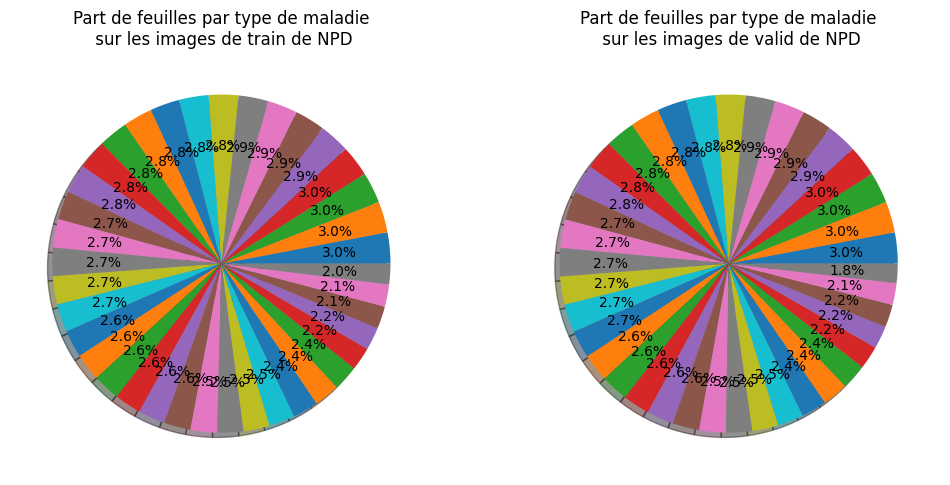

In [25]:
#répartition des feuilles par type de maladie dans chaque jeu de données train et valid
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 12))

plt.subplot(121)
plt.pie(x=df_Select_train['Categorie'].value_counts(),
        autopct='%1.1f%%',
        pctdistance=0.7,
        labeldistance=1.1,
        shadow=True)
plt.title("Part de feuilles par type de maladie\n sur les images de train de NPD");


plt.subplot(122)
plt.pie(x=df_Select_valid['Categorie'].value_counts(),
        autopct='%1.1f%%',
        pctdistance=0.7,
        labeldistance=1.1,
        shadow=True)
plt.title("Part de feuilles par type de maladie\n sur les images de valid de NPD");

In [10]:
#Les classes sont uniformisées. Cependant il y a trop de données, on va uniquement prendre la moitié des images
#Préparation des tables target et data pour le nombre d'images pour chaque jeu de données
target_train = df_Select_train['Categorie']
target_valid = df_Select_valid['Categorie']
#suppression de toutes les colonnes autres que celles des histogrammes d'intensité
colonnes = ['Categorie','Plante','Maladie','Saine','Set','Suffixe','Luminosite']
data_train = df_Select_train.drop(colonnes,axis=1)
data_valid = df_Select_valid.drop(colonnes,axis=1)

In [11]:
#Diminution des données de train (on prend 50%)
X_train, X_trop, y_train, y_trop = train_test_split(data_train, target_train, test_size=0.5, stratify=target_train)
#Nb d'éléments par classe pour train
y_train.value_counts()

Soybean__healthy                                     1011
Apple__Apple_scab                                    1008
Orange__Haunglongbing_(Citrus_greening)              1005
Apple__healthy                                       1004
Apple__Black_rot                                      994
Tomato__Tomato_Yellow_Leaf_Curl_Virus                 981
Potato__Late_blight                                   969
Potato__Early_blight                                  969
Grape__Esca_(Black_Measles)                           960
Tomato__Early_blight                                  960
Pepper,_bell__Bacterial_spot                          957
Corn_(maize)__Northern_Leaf_Blight                    954
Corn_(maize)__Common_rust_                            953
Grape__Black_rot                                      944
Tomato__Leaf_Mold                                     941
Corn_(maize)__healthy                                 930
Tomato__Late_blight                                   925
Peach__Bacteri

In [12]:
#Diminution des données de test (on prend 50%)
X_test, X_trop, y_test, y_trop = train_test_split(data_valid, target_valid, test_size=0.5, stratify=target_valid)
#Nb d'éléments par classe pour train
y_test.value_counts()

Soybean__healthy                                     252
Apple__Apple_scab                                    252
Orange__Haunglongbing_(Citrus_greening)              251
Apple__healthy                                       251
Apple__Black_rot                                     248
Tomato__Tomato_Yellow_Leaf_Curl_Virus                245
Potato__Late_blight                                  242
Potato__Early_blight                                 242
Tomato__Early_blight                                 240
Grape__Esca_(Black_Measles)                          240
Pepper,_bell__Bacterial_spot                         239
Corn_(maize)__Northern_Leaf_Blight                   238
Corn_(maize)__Common_rust_                           238
Grape__Black_rot                                     236
Tomato__Leaf_Mold                                    235
Corn_(maize)__healthy                                232
Tomato__Late_blight                                  231
Peach__Bacterial_spot          

## 2 Classification par type de catégorie (couple plante/maladie)

### 2.1 Modèle de classification Random Forest

In [17]:
#Modèle de classification Random Forest
modelRF = RandomForestClassifier(n_jobs = -1)
# Entraînement
modelRF.fit(X_train,y_train)
# Prédiction
test_pred_RF = modelRF.predict(X_test)
score_RF = accuracy_score(y_test,test_pred_RF)
print("Le score de précision est : ",score_RF*100, "%")

Le score de précision est :  85.54756571967465 %


In [18]:
# Compte-rendu évaluatif détaillé de la classification Random Forest
print("compte rendu évaluatif détaillé de la classification Random Forest \n", classification_report(y_test,test_pred_RF))

compte rendu évaluatif détaillé de la classification Random Forest 
                                                    precision    recall  f1-score   support

                                Apple__Apple_scab       0.90      0.79      0.84       252
                                 Apple__Black_rot       0.82      0.88      0.84       248
                          Apple__Cedar_apple_rust       0.87      0.86      0.87       157
                                   Apple__healthy       0.85      0.78      0.81       251
                               Blueberry__healthy       0.88      0.92      0.90       208
          Cherry_(including_sour)__Powdery_mildew       0.79      0.80      0.79       211
                 Cherry_(including_sour)__healthy       0.91      0.95      0.93       228
Corn_(maize)__Cercospora_leaf_spot Gray_leaf_spot       0.83      0.80      0.81       205
                       Corn_(maize)__Common_rust_       0.95      0.97      0.96       238
               Corn_

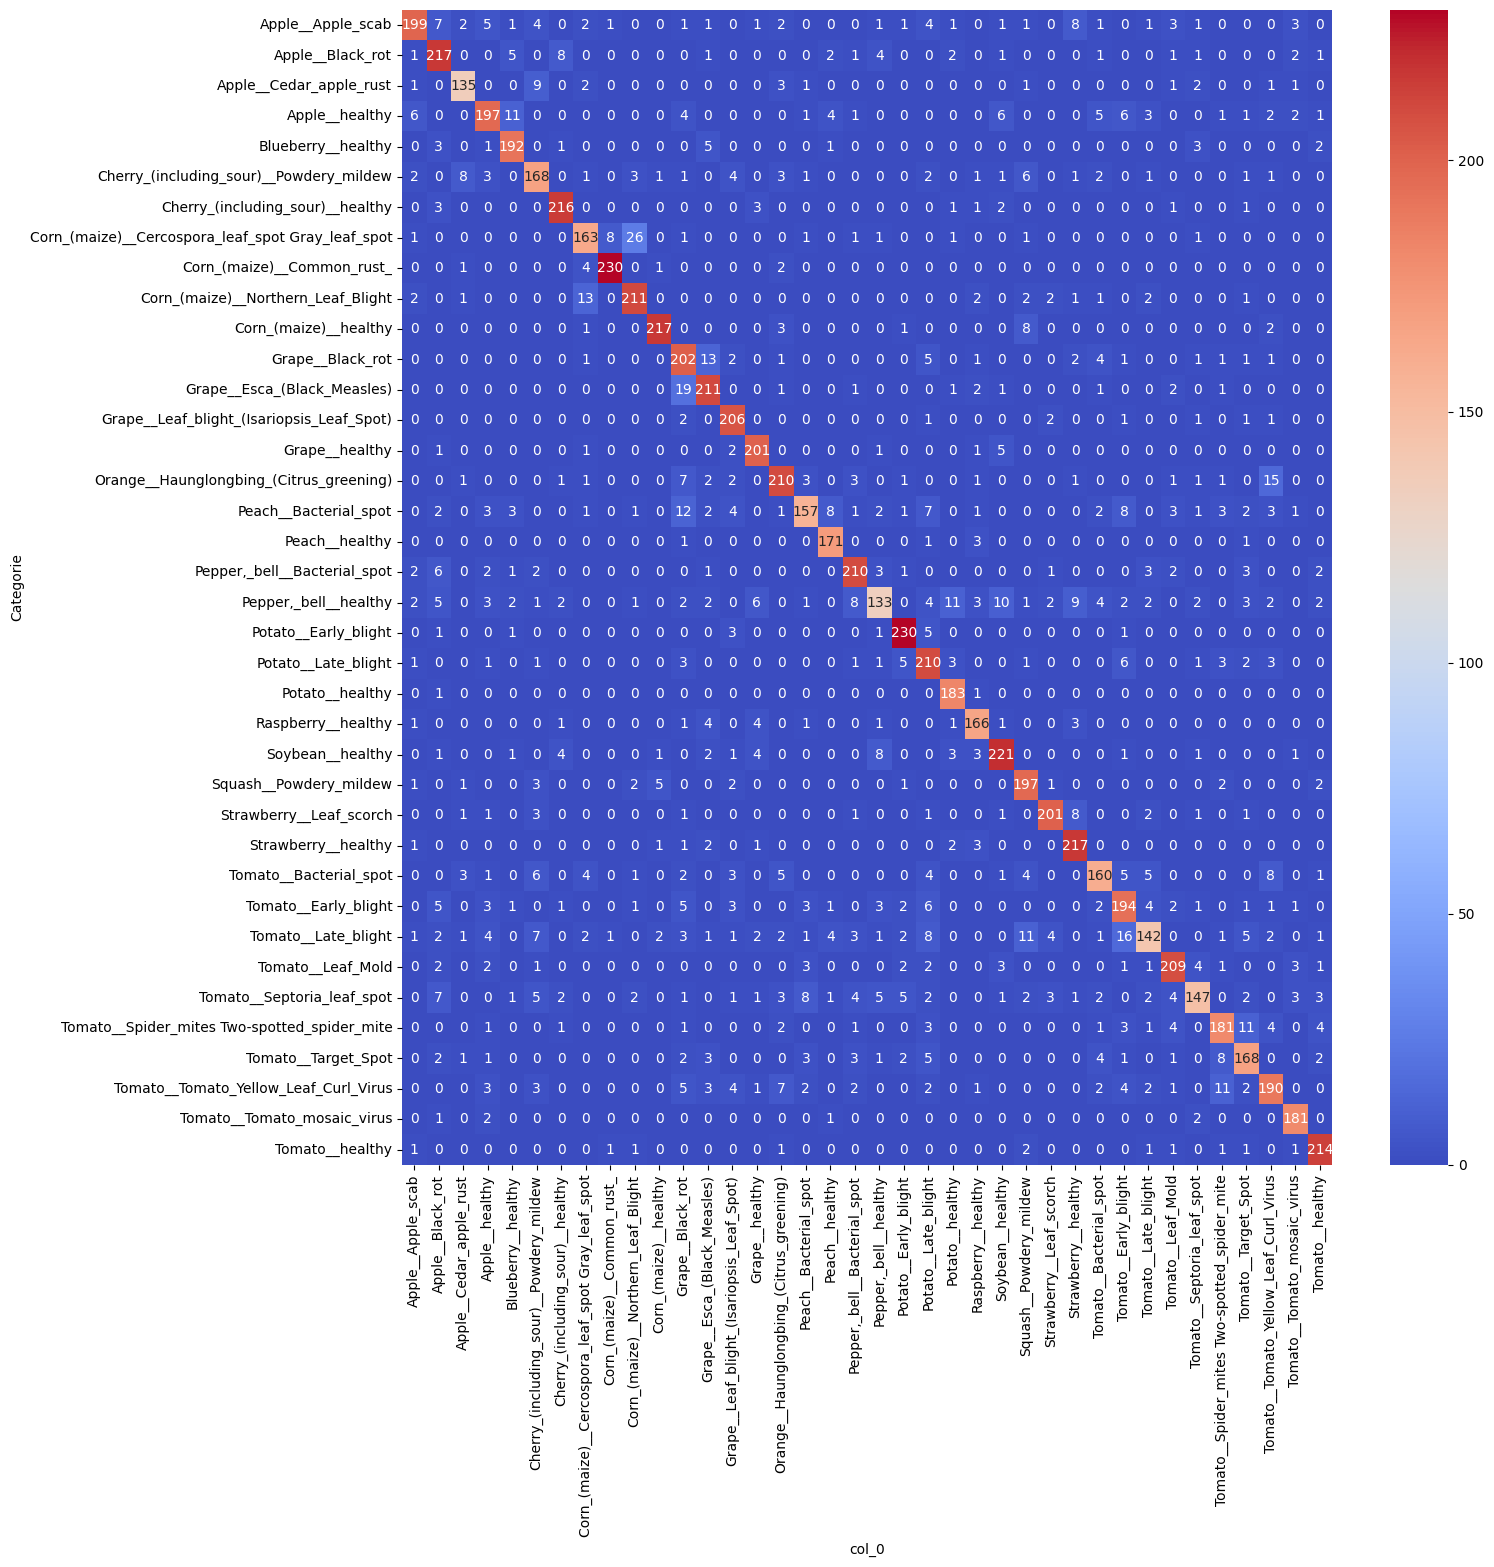

In [22]:
#Heatmap des corrélations
cor = pd.crosstab(y_test, test_pred_RF)
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(cor, annot = True, fmt='d', ax = ax, cmap = "coolwarm");

In [23]:
# Sauvegarde du modèle dans un fichier
nomFicModele = pathRep_mod + '/modelRF_38.pkl'
joblib.dump(modelRF, nomFicModele)

['/content/drive/MyDrive/ProjetPlantes/Donnees/modeles/modelRF_38.pkl']

### 2.2 Modèle de classification par régression logistique

In [49]:
#Modèle de classification régression logistique
modelLR = LogisticRegression(C=1.0,max_iter=2000,solver='sag')
# Entraînement
modelLR.fit(X_train,y_train)
# Prédiction
test_pred_LR = modelLR.predict(X_test)
score_LR = accuracy_score(y_test,test_pred_LR)
print("Le score de précision est : ",score_LR*100, "%")

Le score de précision est :  57.71543086172345 %


In [50]:
# Compte-rendu évaluatif détaillé de la classification par régression logistique
print("compte rendu évaluatif détaillé de la classification par régression logistique \n", classification_report(y_test,test_pred_LR))

compte rendu évaluatif détaillé de la classification par régression logistique 
                                                    precision    recall  f1-score   support

                                Apple__Apple_scab       0.50      0.52      0.51       252
                                 Apple__Black_rot       0.50      0.47      0.48       248
                          Apple__Cedar_apple_rust       0.35      0.32      0.34       157
                                   Apple__healthy       0.52      0.55      0.53       251
                               Blueberry__healthy       0.75      0.74      0.74       208
          Cherry_(including_sour)__Powdery_mildew       0.27      0.22      0.24       211
                 Cherry_(including_sour)__healthy       0.71      0.83      0.76       228
Corn_(maize)__Cercospora_leaf_spot Gray_leaf_spot       0.48      0.40      0.44       205
                       Corn_(maize)__Common_rust_       0.77      0.78      0.78       238
        

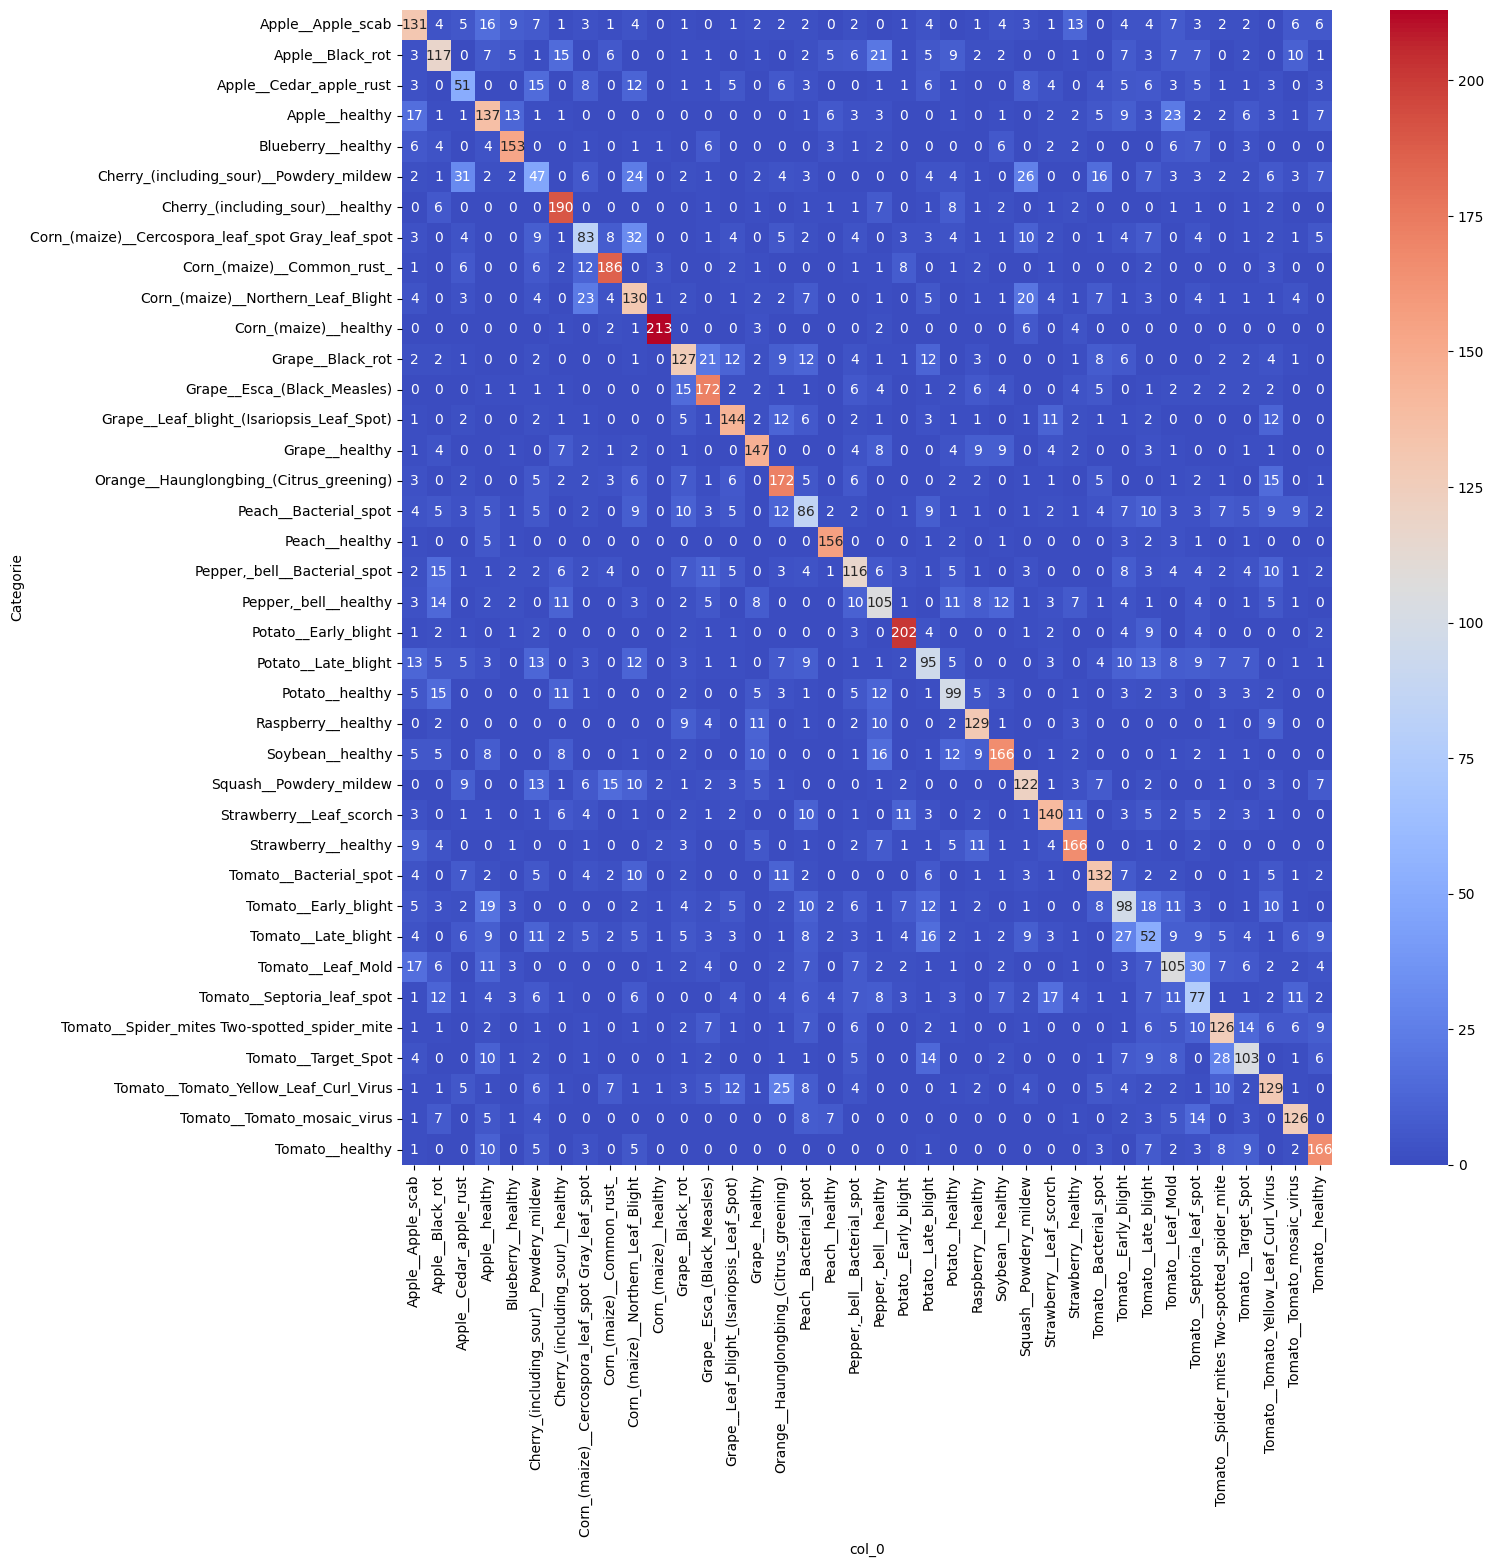

In [51]:
#Heatmap des corrélations
cor = pd.crosstab(y_test, test_pred_LR)
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(cor, annot = True, fmt='d', ax = ax, cmap = "coolwarm");

In [ ]:
# Sauvegarder le modèle
nomFicModele = pathRep_mod + '/modelRL_38.pkl'
joblib.dump(modelLR, nomFicModele)

['/content/drive/MyDrive/ProjetPlantes/Donnees/ModRL_38.pkl']

### 2.3 Modèle de classification par SVM

In [29]:
#Modèle de classification SVM
modelSVM = SVC(gamma=0.01, kernel = 'poly')
# Entraînement
modelSVM.fit(X_train,y_train)
# Prédiction
test_pred_SVM = modelSVM.predict(X_test)
score_SVM = accuracy_score(y_test,test_pred_SVM)
print("Le score de précision est : ",score_SVM*100, "%")

Le score de précision est :  89.76777083578924 %


In [30]:
# Compte-rendu évaluatif détaillé de la classification SVM
print("compte rendu évaluatif détaillé de la classification SVM \n", classification_report(y_test,test_pred_SVM))

compte rendu évaluatif détaillé de la classification SVM 
                                                    precision    recall  f1-score   support

                                Apple__Apple_scab       0.88      0.90      0.89       252
                                 Apple__Black_rot       0.87      0.95      0.91       248
                          Apple__Cedar_apple_rust       0.74      0.87      0.80       157
                                   Apple__healthy       0.85      0.90      0.87       251
                               Blueberry__healthy       0.97      0.93      0.95       208
          Cherry_(including_sour)__Powdery_mildew       0.77      0.80      0.78       211
                 Cherry_(including_sour)__healthy       0.96      0.96      0.96       228
Corn_(maize)__Cercospora_leaf_spot Gray_leaf_spot       0.84      0.87      0.86       205
                       Corn_(maize)__Common_rust_       0.98      0.97      0.98       238
               Corn_(maize)__N

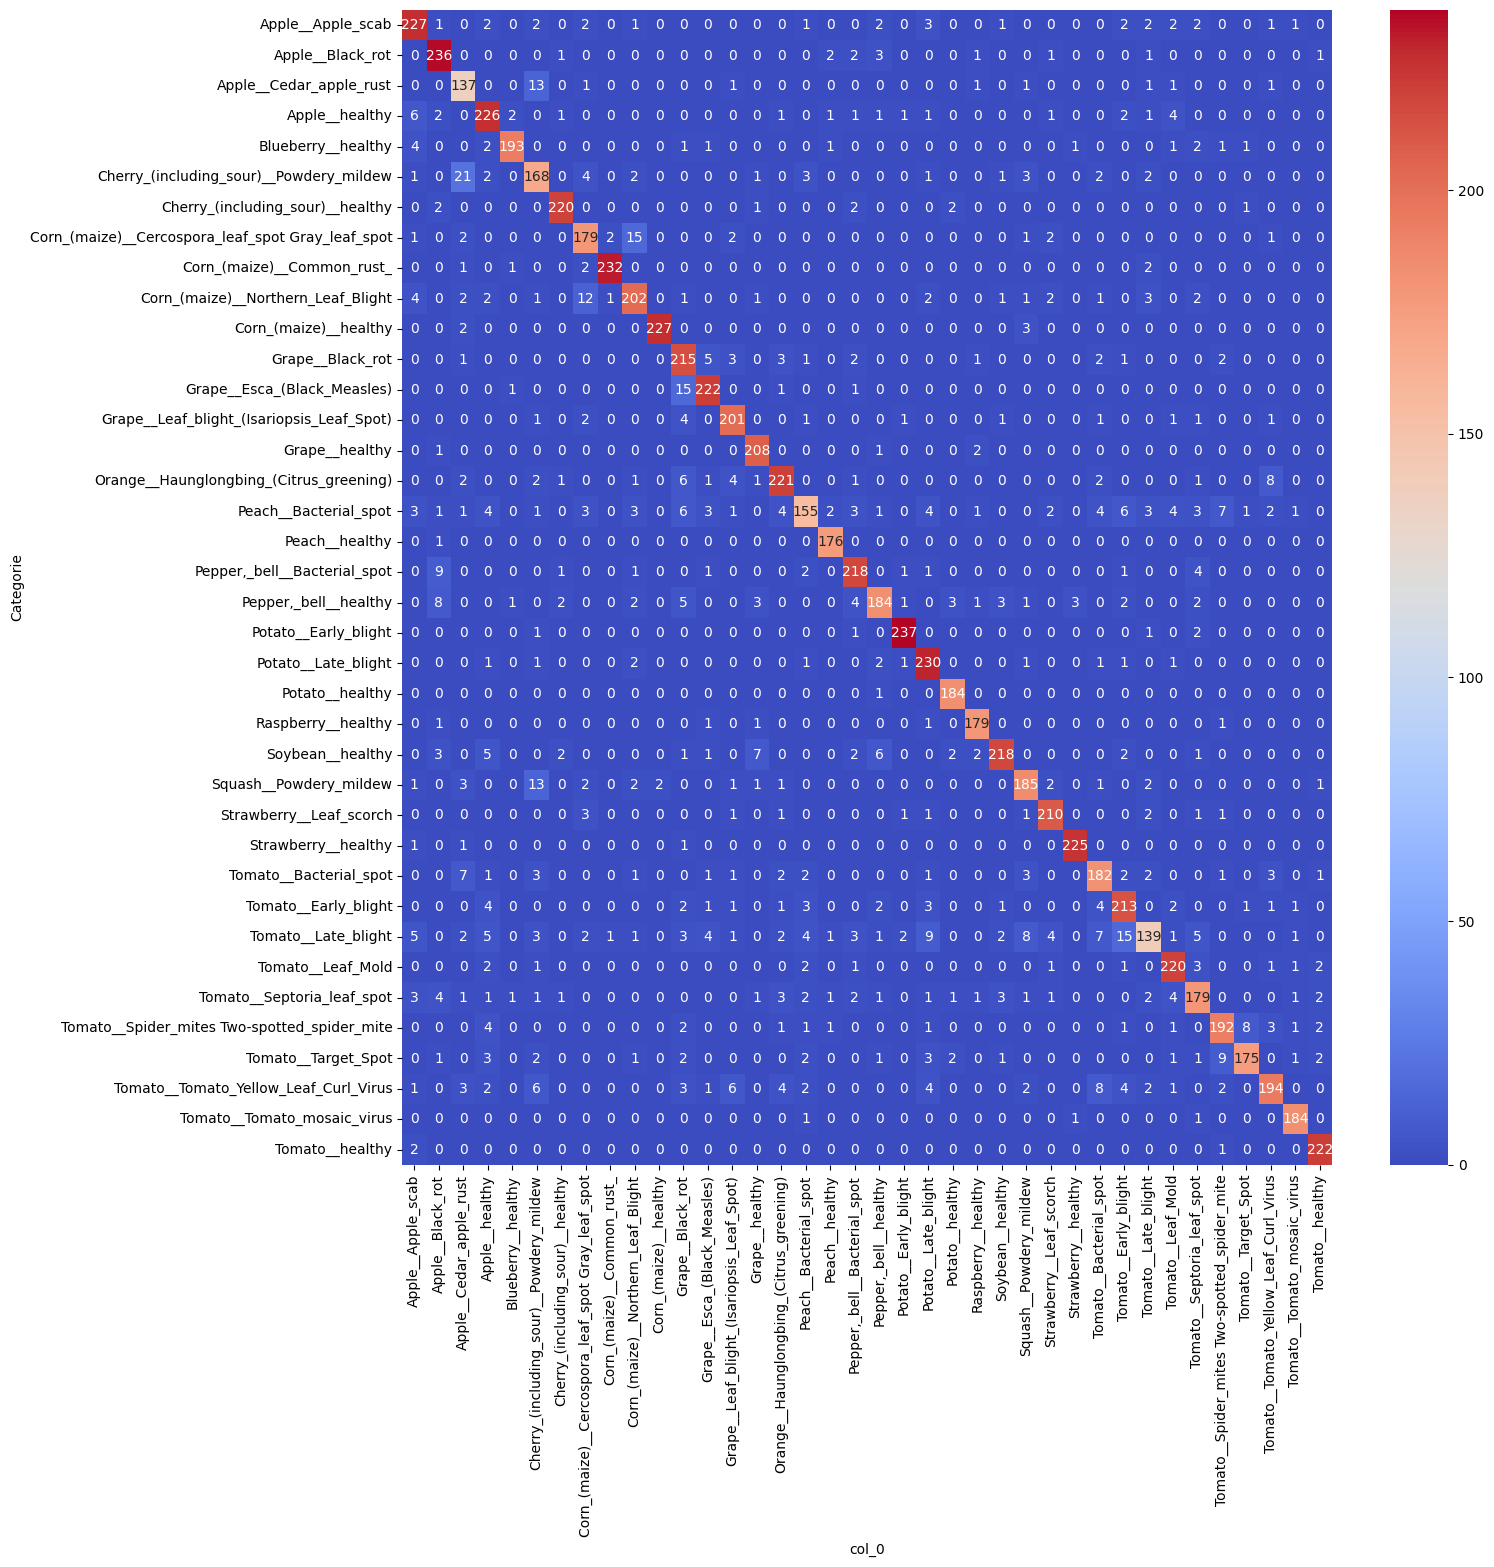

In [32]:
#Heatmap des corrélations
cor = pd.crosstab(y_test, test_pred_SVM)
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(cor, annot = True, fmt='d', ax = ax, cmap = "coolwarm");

In [34]:
# Sauvegarde du modèle dans un fichier
nomFicModele = pathRep_mod + '/modelSVM_38.pkl'
joblib.dump(modelSVM, nomFicModele)

['/content/drive/MyDrive/ProjetPlantes/Donnees/modeles/modelSVM_38.pkl']

### 2.3 Modèle de classification par XGBoots

In [13]:
#Transformation des classes de y_train et y_test par un chiffre au lieu des chaines de caractères
#Il faut concaténer y_train et y_test afin que la correspondance libellé et numéro soit la même pour les deux dataframes
y_cumul = pd.concat([y_train, y_test])

# Utilisation de la méthode factorize sur les colonnes combinées
y_cumul_num, corresp_classe = pd.factorize(y_cumul)

# Mise à jour des colonnes dans les DataFrames originaux
y_train = y_cumul_num[:len(y_train)]
y_test = y_cumul_num[len(y_train):]

In [14]:
#Séparation des données de test en 2 parties
X_test2, X_valid, y_test2, y_valid = train_test_split(X_test, y_test, test_size = 0.5)
#Création des objets DMAtrix
train = xgb.DMatrix(data=X_train,label=y_train)
test = xgb.DMatrix(data=X_test2,label=y_test2)
valid = xgb.DMatrix(data=X_valid,label=y_valid)

In [15]:
paramsXGB = {'booster' : 'gbtree', 'learning_rate' : 0.01, 'objective' : 'multi:softmax', 'num_class': 38}
modelXGB = xgb.train(params = paramsXGB, dtrain = train, num_boost_round = 400, early_stopping_rounds= 15, evals= [(train, 'train'), (test, 'eval')])

[0]	train-mlogloss:3.55899	eval-mlogloss:3.57054
[1]	train-mlogloss:3.48735	eval-mlogloss:3.50982
[2]	train-mlogloss:3.42151	eval-mlogloss:3.45251
[3]	train-mlogloss:3.36090	eval-mlogloss:3.40064
[4]	train-mlogloss:3.30403	eval-mlogloss:3.35193
[5]	train-mlogloss:3.25081	eval-mlogloss:3.30652
[6]	train-mlogloss:3.20049	eval-mlogloss:3.26334
[7]	train-mlogloss:3.15264	eval-mlogloss:3.22285
[8]	train-mlogloss:3.10709	eval-mlogloss:3.18395
[9]	train-mlogloss:3.06368	eval-mlogloss:3.14732
[10]	train-mlogloss:3.02226	eval-mlogloss:3.11196
[11]	train-mlogloss:2.98254	eval-mlogloss:3.07831
[12]	train-mlogloss:2.94442	eval-mlogloss:3.04562
[13]	train-mlogloss:2.90780	eval-mlogloss:3.01467
[14]	train-mlogloss:2.87202	eval-mlogloss:2.98426
[15]	train-mlogloss:2.83743	eval-mlogloss:2.95473
[16]	train-mlogloss:2.80399	eval-mlogloss:2.92634
[17]	train-mlogloss:2.77153	eval-mlogloss:2.89873
[18]	train-mlogloss:2.74018	eval-mlogloss:2.87227
[19]	train-mlogloss:2.70967	eval-mlogloss:2.84654
[20]	train

In [16]:
#Stocke les prédictions sur valid
valid_pred_XGB = modelXGB.predict(valid)
score_XGB = accuracy_score(y_valid, valid_pred_XGB)
print("Le score de précision est : ",score_XGB*100, "%")
#Transformation des prédictions et target pour remettre le libellé de la classe
y_valid_label = pd.Series(y_valid).map({i: classe for i, classe in enumerate(corresp_classe)})
valid_pred_XGB_label = pd.Series(valid_pred_XGB).map({i: classe for i, classe in enumerate(corresp_classe)})
# Compte-rendu évaluatif détaillé de la classification XGBoost
print("compte rendu évaluatif détaillé de la classification XGBoost \n", classification_report(y_valid_label, valid_pred_XGB_label))

Le score de précision est :  80.99952852428099 %
compte rendu évaluatif détaillé de la classification XGBoost 
                                                    precision    recall  f1-score   support

                                Apple__Apple_scab       0.86      0.71      0.78       135
                                 Apple__Black_rot       0.75      0.88      0.81       125
                          Apple__Cedar_apple_rust       0.71      0.70      0.70        73
                                   Apple__healthy       0.88      0.79      0.84       131
                               Blueberry__healthy       0.84      0.96      0.90        94
          Cherry_(including_sour)__Powdery_mildew       0.72      0.74      0.73       120
                 Cherry_(including_sour)__healthy       0.93      0.94      0.93       118
Corn_(maize)__Cercospora_leaf_spot Gray_leaf_spot       0.74      0.58      0.65       106
                       Corn_(maize)__Common_rust_       0.96      0.

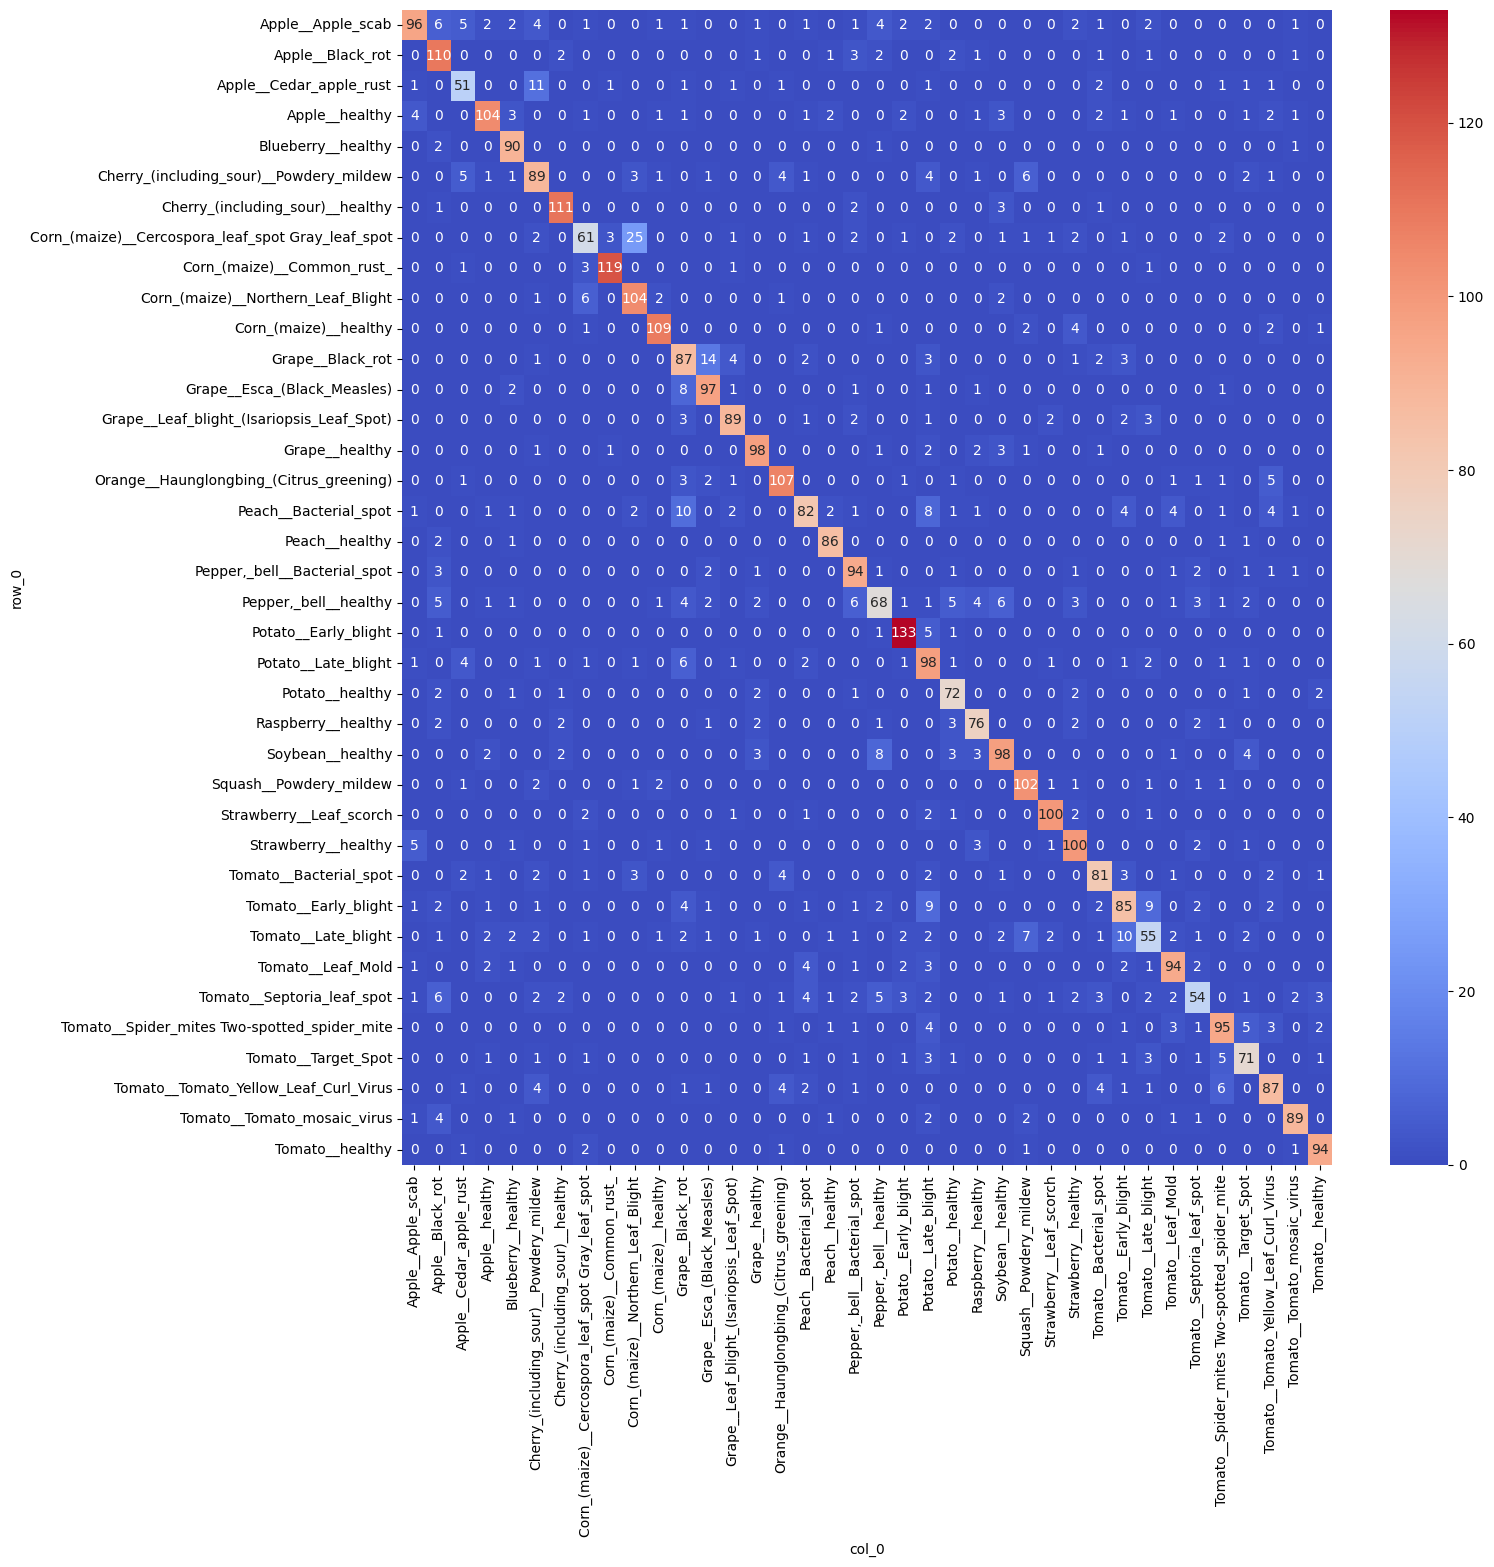

In [17]:
#Heatmap des corrélations
cor = pd.crosstab(y_valid_label, valid_pred_XGB_label)
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(cor, annot = True, fmt='d', ax = ax, cmap = "coolwarm");

In [18]:
# Sauvegarde du modèle dans un fichier
nomFicModele = pathRep_mod + '/modelXGB_38.bin'
modelXGB.save_model(nomFicModele)